In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import psutil
from pympler import asizeof
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

def prepare_data_as_paper(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES - 1, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [3]:
def weighted_cross_entropy(y_true, y_pred):
    p = tf.reduce_sum(y_true)
    n = tf.cast(tf.size(y_true), tf.float32) - p
    beta_p = (p + n) / (p + 1e-7)
    beta_n = (p + n) / (n + 1e-7)
    loss = -beta_p * y_true * tf.math.log(y_pred + 1e-7) - beta_n * (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) # Add epsilon to avoid log(0)
    return tf.reduce_mean(loss)

In [4]:
def weighted_cross_entropy2(y_true, y_pred):
    tf.print("y_true", y_true, summarize=-1)
    tf.print("y_pred", y_pred, summarize=-1)

    positive_cases = tf.equal(y_true[:, -1], 0)  # Positive when last column is 0
    negative_cases = tf.equal(y_true[:, -1], 1)  # Negative when last column is 1
    positive_cases = tf.cast(positive_cases, tf.float32)
    negative_cases = tf.cast(negative_cases, tf.float32)
    
    tf.print("positive_cases", positive_cases, summarize=-1)
    tf.print("negative_cases", negative_cases, summarize=-1)
    
    count_positive = tf.reduce_sum(positive_cases)
    count_negative = tf.reduce_sum(negative_cases)
    
    tf.print("count_positive", count_positive, summarize=-1)
    tf.print("count_negative", count_negative, summarize=-1)
    
    total_samples = tf.cast(tf.shape(y_true)[0], tf.float32)
    
    tf.print("total_samples", total_samples)

    beta_p = total_samples / count_positive
    beta_n = total_samples / count_negative
    
    beta_p = tf.clip_by_value(beta_p, 1e-7, 1e7) #  Clipping 
    beta_n = tf.clip_by_value(beta_n, 1e-7, 1e7)
    
    tf.print("beta_p", beta_p, summarize=-1)
    tf.print("beta_n", beta_n, summarize=-1)
    
    y_pred_binary = tf.stack([tf.reduce_sum(y_pred[:, :-1], axis=-1), y_pred[:, -1]], axis=-1)

    
    y_pred_binary = tf.cast(y_pred_binary, tf.float32)

    tf.print("y_pred_binary", y_pred_binary, summarize=-1)
    
    weighted_positive_loss = beta_p * tf.reduce_sum(-positive_cases * tf.math.log(y_pred_binary[:, 0] + 1e-7))
    weighted_negative_loss = beta_n * tf.reduce_sum(-negative_cases * tf.math.log(y_pred_binary[:, 1] + 1e-7))
    
    tf.print("weighted_positive_loss", weighted_positive_loss, summarize=-1)
    tf.print("weighted_negative_loss", weighted_negative_loss, summarize=-1)   
    
    return weighted_positive_loss + weighted_negative_loss

In [3]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [ ]:
def create_model_1(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUMBER_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_2(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        # BatchNormalization(), # new
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'), # new
        Conv2D(128, (3, 3), activation='relu'), # new
        # BatchNormalization(),
        MaxPooling2D((2, 2)), # new
        Dropout(0.3), # new
        Flatten(),
        Dense(256, activation='relu'), # former 128
        Dropout(0.5),
        Dense(NUMBER_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

def create_model_3(image_size):
    model = Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(256, (3, 3), activation='relu', padding='same'), # new
        Conv2D(256, (3, 3), activation='relu', padding='same'), # new
        MaxPooling2D((2, 2)), # new
        Dropout(0.3), # new
        Flatten(),
        Dense(512, activation='relu'), # former 256
        Dropout(0.5),
        Dense(NUMBER_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC()])

    return model

In [4]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [7]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    images_test = tf.cast(images_test, np.float32) / 255.0
    
    predictions = model.predict(images_test, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [8]:
NUMBER_OF_IMAGES = 1000
IMAGE_SIZE = 1024
BATCH_SIZE = 16

images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)

train_dataset = create_train_dataset(images_train, labels_train)

val_dataset = create_val_dataset(images_val, labels_val)

100%|██████████| 200/200 [00:02<00:00, 92.31it/s]
2025-03-04 07:39:22.847285: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-04 07:39:22.847511: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-04 07:39:22.847537: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-04 07:39:22.847764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-04 07:39:22.847838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
model = create_resnet_model(IMAGE_SIZE)

steps_per_epoch = len(images_train) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

# class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels_train.argmax(axis=1)), y=labels_train.argmax(axis=1))
# class_weights = {i: class_weights[i] for i in range(len(class_weights))}

model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

In [ ]:
# Resolution

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 1000
evaluations = {}

for ev_image_size in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    
    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
    
    train_dataset = create_train_dataset(images_train,labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
    
    model = create_resnet_model(ev_image_size)
    
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE

    model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        batch_size=BATCH_SIZE,
        verbose=1
    )
    evals = evaluate_model(model, images_test, labels_test)
    
    evaluations[ev_image_size] = evals
    print(f'\n{evals}\n')
    
print(evaluations)

In [ ]:
with open("pickles/resolution_1000samples.pkl", "wb") as file:
    pickle.dump(evaluations, file)

In [ ]:
plt.figure(figsize=(8, 6))

aucs = [evalu[0] for evalu in evaluations.values()]
aucs_at = [evalu[0] for evalu in aucs]
aucs_ef = [evalu[1] for evalu in aucs]
aucs_in = [evalu[2] for evalu in aucs]
aucs_nf = [evalu[3] for evalu in aucs]
baccs = [evalu[1] for evalu in evaluations.values()]
accs = [evalu[2] for evalu in evaluations.values()]

x_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

font_size = 16

plt.plot(x_values, accs, label="Accuracy")
plt.plot(x_values, baccs, label="Balanced Accuracy")

# plt.plot(x_values, aucs_at, label="Atelectasis")
# plt.plot(x_values, aucs_ef, label="Effusion")
# plt.plot(x_values, aucs_in, label="Infiltration")
# plt.plot(x_values, aucs_nf, label="No Finding")

plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="center left")

plt.savefig("evals/chestxray8/resolution_accsBaccs_1000_samples.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

All labels: 10000 samples, 50 epochs: 
[0.6692994173103355, 0.5939930395255514, 0.6683094818155433, 0.5533819389301956, 0.6756526600600586, 0.5141695372704997, 0.5874413145539906, 0.814388249040227, 0.6113292270077111, 0.5362483786464559, 0.5052575717787114, 0.39618781165543754, 0.4708606350806452, 0.5637999231950844]

In [13]:
# Resolution for multiple runs

BATCH_SIZE = 16
NUMBER_OF_IMAGES = 10000
evaluations = {}

# for ev_image_size in [100, 200, 224, 300, 400, 500, 768, 1024]:
for ev_image_size in [32, 112, 224]:
    
    evals_per_size = []

    for i in range(5):     
        
        tf.keras.backend.clear_session()
        
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        images, labels = prepare_data(df[:NUMBER_OF_IMAGES], ev_image_size)
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
        images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], ev_image_size)
        
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
        
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        model = create_resnet_model(ev_image_size)
                
        model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=40,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            batch_size=BATCH_SIZE,
            verbose=1)
        
        evals = evaluate_model(model, images_test, labels_test)
        evals_per_size.append(evals)
        
    evaluations[ev_image_size] = evals_per_size
    print(f'\n{evals_per_size}\n')
    
print(evaluations)

 57%|█████▋    | 5735/10000 [01:19<00:59, 71.86it/s]


KeyboardInterrupt: 

In [10]:
# 20 epochs

evaluations = {}
evaluations[32] = [([0.6338036541655739, 0.6786923784849304, 0.6046562950444853, 0.6592096443897533], 0.25, 0.6845), ([0.6606437267041, 0.7024752307466362, 0.6011493762413108, 0.658043833443105], 0.25, 0.7095), ([0.6301414515077548, 0.6888848541809068, 0.6085510907003444, 0.6432579702142742], 0.25, 0.6905), ([0.6377228810644189, 0.6973801801801802, 0.5865044638910988, 0.6435441720003087], 0.25, 0.6815), ([0.5868017045122876, 0.679469238206707, 0.5945928123969667, 0.6412990683856825], 0.25, 0.6825)]
evaluations[50] = [([0.6360955566719354, 0.7241243046619315, 0.6042250287026407, 0.6611792183623555], 0.26028088325268367, 0.6825), ([0.6369431643625193, 0.7028293124470159, 0.6133932912007778, 0.6615378611106839], 0.25, 0.6965), ([0.6322589143312828, 0.6955195849642515, 0.6577387512917637, 0.6788985991878943], 0.25, 0.691), ([0.6488415641376167, 0.6769080496943919, 0.6636834736973268, 0.6650430504305044], 0.25876440359495617, 0.676), ([0.6554661213867459, 0.6876787811733933, 0.628791556487124, 0.6590728651317272], 0.25694129186591613, 0.6855)]
evaluations[100] = [([0.6197388632872505, 0.680058475412146, 0.6290277841561425, 0.6656434638371698], 0.25, 0.6735), ([0.6587685633238778, 0.7044769021739129, 0.6162749530950105, 0.6466313390313391], 0.2526236416056775, 0.676), ([0.5782203602724948, 0.7128110944793005, 0.6431967996779551, 0.6602712781878424], 0.2513141237641761, 0.684), ([0.658563688274609, 0.6618415929695755, 0.6123666666666667, 0.6537911198473724], 0.25, 0.706), ([0.5927799981410912, 0.7316908443669008, 0.5929354333609652, 0.6567398063511249], 0.24964106245513282, 0.6955)]
evaluations[112] = [([0.629630861077862, 0.7296835355690733, 0.6278619232123988, 0.6699961054464811], 0.2569356603573552, 0.6835), ([0.6816965154759588, 0.7072661160242505, 0.6123196078431372, 0.6639795436588233], 0.25470382073073294, 0.7035), ([0.6049223905567432, 0.714197774056929, 0.6104817168646955, 0.669694672468012], 0.25894488677151994, 0.695), ([0.6229723502304148, 0.7076055365313227, 0.6615039038765342, 0.6860681850767772], 0.2976553794407252, 0.688), ([0.6276004410210629, 0.7215429122468661, 0.6359019961154143, 0.6704907254616685], 0.2589399549885702, 0.695)]
evaluations[200] = [([0.6148617511520738, 0.6444386892143791, 0.6392275033418398, 0.6630950341018638], 0.24981844589687727, 0.688), ([0.5883396472594509, 0.6878688524590164, 0.59572227552477, 0.6400448819203252], 0.2498197548666186, 0.693), ([0.6338477578183133, 0.724407676463696, 0.6151630786953705, 0.6810754442814433], 0.25, 0.686), ([0.5903349219460101, 0.6758608034270781, 0.6038941850112063, 0.6475586796109355], 0.25, 0.681), ([0.5873042344486726, 0.6498677895759994, 0.6007036260730012, 0.6348739378354205], 0.24981831395348839, 0.6875)]
evaluations[224] = [([0.5402481358676193, 0.6404963069238536, 0.6226374582910199, 0.6205480213493924], 0.24964106245513282, 0.6955), ([0.569605734767025, 0.673289008896273, 0.5623993650504313, 0.6144201092117758], 0.25024654832347143, 0.675), ([0.5886318734155084, 0.654409107062043, 0.6151737163874943, 0.6497067161820663], 0.2498173849525201, 0.684), ([0.6224824430900162, 0.6452470523552915, 0.5788271164349552, 0.6279773276130799], 0.24982381959126146, 0.709), ([0.6146583483679255, 0.665014809751652, 0.5930066590126291, 0.634677407090692], 0.2498189717595945, 0.69)]
# evaluations[224] = [([0.5849114753860601, 0.6395196513682945, 0.5766768467264746, 0.5975324488097065], 0.24963609898107714, 0.686), ([0.6007019735308476, 0.6354853037928604, 0.6220221918788859, 0.6467774844763136], 0.25044234285727296, 0.701), ([0.6075790003776911, 0.6233531853456056, 0.5931963173137351, 0.6230765521370074], 0.2498197548666186, 0.693), ([0.5933531271587227, 0.6799333961544047, 0.5901827929753461, 0.6250411701688756], 0.25, 0.6835), ([0.6084911855700192, 0.6699969408754657, 0.5892245649342038, 0.6294325989270375], 0.2502897944834532, 0.696)]
evaluations[300] = [([0.5627874201401992, 0.6410054054054054, 0.5762157842010666, 0.6058698664295562], 0.25, 0.6815), ([0.5821828848286731, 0.646407943616101, 0.5924789223305543, 0.611870439272014], 0.25, 0.6825), ([0.5961550243221055, 0.6557337737563286, 0.5558319173363949, 0.5981359668397571], 0.24981923355025307, 0.691), ([0.6205875576036867, 0.6475332597043356, 0.600084110779298, 0.6352615040370125], 0.25, 0.6965), ([0.6110019366598314, 0.6195505638870552, 0.6194843461501904, 0.6449039663917496], 0.25, 0.691)]
evaluations[400] = [([0.5934972374117111, 0.5998608347952212, 0.5755528435619471, 0.5880145313081038], 0.2525428429130917, 0.6765), ([0.5845004182544846, 0.6161074283093306, 0.5862846220770295, 0.6072660580993423], 0.24970656517781326, 0.681), ([0.5751652471546307, 0.5684800611542872, 0.5968600878030158, 0.590612516334854], 0.24981804949053857, 0.6865), ([0.6093402944242367, 0.5903563759263403, 0.6226812440936232, 0.622820684558454], 0.24964362081254454, 0.7005), ([0.6054196757961079, 0.5999978767901314, 0.6130195677673574, 0.6240004187097388], 0.25, 0.6935)]
evaluations[448] = [([0.5948434235362865, 0.6088043759789834, 0.5820414975141738, 0.615635619579952], 0.25, 0.686), ([0.556728679009231, 0.6221829905306087, 0.5689762365294281, 0.6047993224052771], 0.25026102751873675, 0.68), ([0.5930502281720463, 0.6005039023657193, 0.5949828567294714, 0.6089860055158021], 0.2504404864278771, 0.6875), ([0.512282258441134, 0.5636324990700887, 0.5985066976159389, 0.5816680484086708], 0.2498205312275664, 0.696), ([0.5417816242678556, 0.5930463887935512, 0.5607502810183497, 0.5764054395865293], 0.25326676528599606, 0.6765)]
evaluations[500] = [([0.5, 0.5, 0.5, 0.5], 0.25, 0.6735), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.675), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.6835), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.706), ([0.5, 0.5, 0.5, 0.5], 0.25, 0.6965)]

In [12]:
# with open("pickles/resolution_10000samples_5runs_.pkl", "wb") as file:
#     pickle.dump(evaluations, file)

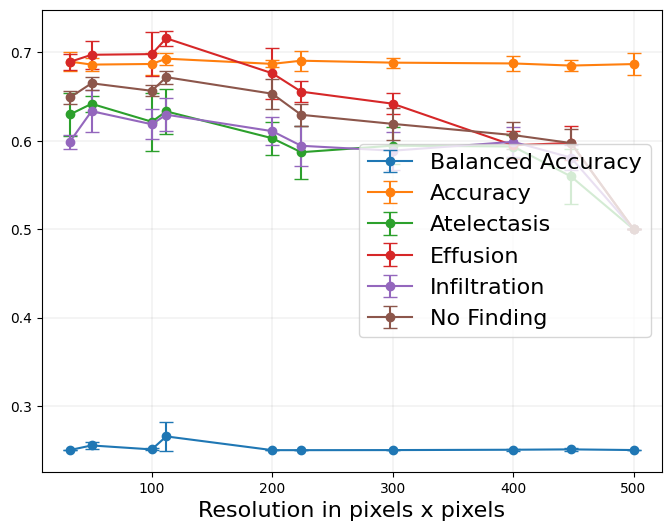

In [11]:
plt.figure(figsize=(8, 6))

aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []


for evals_per_size in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_size:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))

x_values = [32, 50, 100, 112, 200, 224, 300, 400, 448, 500]#, 768, 1024]

font_size = 16

plt.errorbar(x_values, baccs_means, yerr=baccs_stds, label='Balanced Accuracy', fmt='-o', capsize=5)
plt.errorbar(x_values, accs_means, yerr=accs_stds, label='Accuracy', fmt='-o', capsize=5)

plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-o', capsize=5)
plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-o', capsize=5)

plt.xlabel("Resolution in pixels x pixels", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="center right")

# plt.savefig("evals/chestxray8/resolution_accBaccs_10000_samples_5runs_onlyfirst5.pdf", bbox_inches='tight', pad_inches=0)

plt.show()